# 색 분류

## 이미지 resize

In [1]:
import numpy as np
import cv2
import json
import pycocotools.mask as mask
from glob import glob
import os

image_paths = glob(os.path.join('data', 'cropped_color_image_add','*.jpg'))
image_paths.sort()

len(image_paths)

22275

In [ ]:
for i in range(len(image_paths)):
    filename = image_paths[i].split('/')[-1]
    original_image = cv2.imread('./data/cropped_color_image_add/' + filename)
    resizeHeight = int(600)
    resizeWidth  = int(600)
    resized_image = cv2.resize(original_image, (resizeHeight, resizeWidth), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite('./data/cropped_color_image_resize/' + filename, resized_image)
    cv2.waitKey(0)

## 필요한 패키지 import 및 시각화

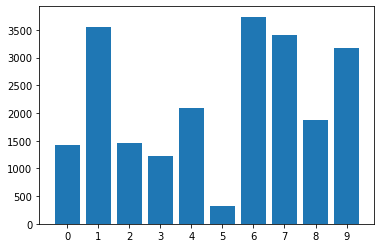

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os.path as pth
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout
from tensorflow.keras.layers import Dense,  MaxPooling2D, Add, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 제한된 메모리만 할당
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=13000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

# strategy = tf.distribute.MirroredStrategy()


color_mapping = {'갈색' : 0, '검정색' : 1, '노란색' : 2, '보라색' : 3, '분홍색' : 4, 
                 '빨간색' : 5, '초록색' : 6, '파란색' : 7, '회색' : 8, '흰색' : 9}

train_data = pd.read_csv('./data/cropped_color_add.csv')
colors = train_data['color'].unique()
colors.sort()

values = []
for i in range(10):
    values.append(sum(train_data['color']==i))
    
x = np.arange(10)

plt.bar(x, values)
plt.xticks(x, colors)
plt.show()

# color_mapping = {'갈색' : 0, '검정색' : 1, '노란색' : 2, '보라색' : 3, '분홍색' : 4, 
#                  '빨간색' : 5, '초록색' : 6, '파란색' : 7, '회색' : 8, '흰색' : 9}

## 데이터 변환 및 TFrecod 생성

In [3]:
for i in range(len(train_data)):
    train_data['file_name'][i] = str(train_data['file_name'][i]) + '.jpg'

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
path = './data/cropped_color_image_resize/'
train_data

,file_name,color
0,1.jpg,1
1,10.jpg,1
2,1000.jpg,1
3,10000.jpg,4
4,10001.jpg,4
...,...,...
22270,9991.jpg,4
22271,9993.jpg,4
22272,9995.jpg,4
22273,9998.jpg,4


In [25]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

In [26]:
def to_tfrecords(id_list, color_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, color_id in tqdm(zip(id_list, color_id_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(path, id_)
            _binary_image = tf.io.read_file(image_path)
            
            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'color_id': _int64_feature(color_id),
                'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [27]:
with tf.device('/device:GPU:0'):
    train_ids, val_ids, train_color_ids, val_color_ids = train_test_split(train_data['file_name'], train_data['color'], test_size=0.1, random_state=42, shuffle=True,
                                                                                stratify=train_data['color'])

    to_tfrecords(train_ids, train_color_ids, pth.join(path, 'tf_record_train'))
    to_tfrecords(val_ids, val_color_ids, pth.join(path, 'tf_record_valid'))

  0%|          | 40/20047 [00:00<00:52, 384.55it/s]

Start converting


  2%|▏         | 37/2228 [00:00<00:06, 353.41it/s]

Start converting


100%|██████████| 2228/2228 [00:06<00:00, 361.49it/s]


In [ ]:
def to_test_tfrecords(id_list, test_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, test_id in tqdm(zip(id_list, test_id_list), total=len(id_list), position=0, leave=True):
            image_path = id_
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'id': _bytes_feature(test_id.encode()),
            }))

            writer.write(string_set.SerializeToString())    
            

In [ ]:
with tf.device('/device:GPU:1'):
    to_test_tfrecords(test_data['file_name'],test_data['color'], pth.join(path, 'tf_record_test'))

In [ ]:
## test는 추후 수정

# def to_test_tfrecords(id_list, test_id_list, tfrecords_name):
#     print("Start converting")
#     options = tf.io.TFRecordOptions(compression_type = 'GZIP')
#     with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
#         for id_, test_id in tqdm(zip(id_list, test_id_list), total=len(id_list), position=0, leave=True):
#             image_path = id_
#             _binary_image = tf.io.read_file(image_path)

#             string_set = tf.train.Example(features=tf.train.Features(feature={
#                 'image_raw': _bytes_feature(_binary_image),
#                 'id': _bytes_feature(test_id.encode()),
#             }))

#             writer.write(string_set.SerializeToString())    

# with tf.device('/device:GPU:1'):
#     test_ids = test_data['id']
#     to_test_tfrecords(test_data['file'],test_data['id'], pth.join(path, 'tf_record_test'))

## TFrecord 읽어 들이기, Augmentation

In [5]:
train_tfrecord_path = pth.join(path, 'tf_record_train.tfrecords')
valid_tfrecord_path = pth.join(path, 'tf_record_valid.tfrecords')

BUFFER_SIZE = 256
BATCH_SIZE = 32
NUM_CLASS = 10

In [6]:
with tf.device('/device:GPU:0'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'color_id': tf.io.FixedLenFeature([], tf.int64),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }


    
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['color_id']
    img = tf.image.decode_jpeg(img, channels=3)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_left_right(img)
    img = tf.cast(img, tf.float32)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def prep_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image, (600,600))
    result_image = tf.image.central_crop(result_image, 0.5)
#     result_image = tf.image.random_brightness(result_image, 0.2)
    onehot_label = tf.one_hot(label, depth=NUM_CLASS)
    return result_image, onehot_label

with tf.device('/device:GPU:0'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Baseline CNN

In [7]:
model = Sequential()

model.add(Conv2D(32, (8, 8), strides=(1, 1), activation='relu', input_shape=(160, 120, 3)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 153, 113, 32)      6176      
_________________________________________________________________
batch_normalization (BatchNo (None, 153, 113, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 76, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 52, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 52, 64)        256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 36, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 24, 128)       7

In [13]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 2, 
                        factor = 0.8, 
                        min_lr=0.0001,
                        verbose=1)
model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="clothes_color_base_CNN_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)


callbacks = [earlystop, learning_rate_reduction, model_check]

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00005),
              metrics=['categorical_accuracy'])

In [15]:
# import tensorflow as tf
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_valid, y_valid), callbacks = callbacks)
with tf.device('/device:GPU:0'):
    history = model.fit(dataset,
                        epochs=100,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Epoch 1/100
627/627 [==============================] - 23s 37ms/step - loss: 1.4161 - categorical_accuracy: 0.5720 - val_loss: 1.2644 - val_categorical_accuracy: 0.6158
Epoch 2/100
627/627 [==============================] - 22s 36ms/step - loss: 1.3746 - categorical_accuracy: 0.5845 - val_loss: 1.9323 - val_categorical_accuracy: 0.4484
Epoch 3/100
627/627 [==============================] - 23s 36ms/step - loss: 1.3462 - categorical_accuracy: 0.5879 - val_loss: 1.2106 - val_categorical_accuracy: 0.6252
Epoch 4/100
627/627 [==============================] - 22s 36ms/step - loss: 1.3293 - categorical_accuracy: 0.5972 - val_loss: 1.2547 - val_categorical_accuracy: 0.5983
Epoch 5/100
627/627 [==============================] - 24s 38ms/step - loss: 1.3017 - categorical_accuracy: 0.6016 - val_loss: 1.2839 - val_categorical_accuracy: 0.5934
Epoch 6/100
627/627 [==============================] - 23s 36ms/step - loss: 1.2924 - categorical_accuracy: 0.6066 - val_loss: 1.1613 - val_categorical_acc

In [6]:
from tensorflow.keras.models import load_model
# with strategy.scope():
with tf.device('/device:GPU:0'):  
    baseCNN = load_model("clothes_color_base_CNN_model.h5")
    baseCNN.summary()

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 1, 
                        factor = 0.8, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./clothes_color_base_CNN_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in baseCNN.layers:
    layer.trainable = True
 
# with strategy.scope(): 
with tf.device('/device:GPU:0'):  
    model = baseCNN
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['categorical_accuracy'])
    
    history = model.fit(dataset,
                        epochs=30,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 158, 118, 1024)    28672     
_________________________________________________________________
batch_normalization_4 (Batch (None, 158, 118, 1024)    4096      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 79, 59, 1024)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 79, 59, 1024)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 77, 57, 512)       4719104   
_________________________________________________________________
batch_normalization_5 (Batch (None, 77, 57, 512)       2048      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 28, 512)      

KeyboardInterrupt: 

## MobileNetV2

In [9]:
from tensorflow.keras import models
from tensorflow.keras.applications import MobileNetV2 

mobilenetV2 = MobileNetV2(weights ='imagenet', include_top = False, 
                              input_shape = (224, 224, 3), classifier_activation='softmax')

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="clothes_color_mobilenetV2.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

# print(mobilenetV2.summary())    
# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in mobilenetV2.layers:
    layer.trainable = True
    

with tf.device('/device:GPU:0'):  
    model = models.Sequential()
    model.add(mobilenetV2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='softmax')) 
    model.summary()
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(10, activation='softmax')) 
#     model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    
    history = model.fit(dataset,
                        epochs=10,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
      2/Unknown - 0s 96ms/step - loss: 2.6428 - accuracy: 0.1250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0465s vs `on_train_batch_end` time: 0.1446s). Check your callbacks.
627/627 [==============================] - 138s 219ms/step - loss: 1.3665 - accuracy: 0.5452 - val_loss: 6.5762 - val_a

In [10]:
from tensorflow.keras.models import load_model
# with strategy.scope():
with tf.device('/device:GPU:0'):  
    mobilenetV2_load = load_model("clothes_color_mobilenetV2.h5")
    mobilenetV2_load.summary()

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 1, 
                        factor = 0.8, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./clothes_color_mobilenetV2.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in mobilenetV2_load.layers:
    layer.trainable = True
 
# with strategy.scope(): 
with tf.device('/device:GPU:0'):  
    model = mobilenetV2_load
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00005),
                  metrics=['categorical_accuracy'])
    
    history = model.fit(dataset,
                        epochs=10,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________

## DenseNet201

In [18]:
from tensorflow.keras import models
from tensorflow.keras.applications import DenseNet201 

densenet201 = DenseNet201(weights ='imagenet', include_top = False, input_shape=(160,120,3))

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 1, 
                        factor = 0.8, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./clothes_color_densenet201_crop.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in densenet201.layers:
    layer.trainable = True
 
# with strategy.scope(): 
with tf.device('/device:GPU:0'):  
    model = models.Sequential()
    model.add(densenet201)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='softmax')) 
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00007),
                  metrics=['accuracy'])
    
    history = model.fit(dataset,
                        epochs=30,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 5, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                19210     
Total params: 18,341,194
Trainable params: 18,112,138
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/30
627/627 [==============================] - 153s 244ms/step - loss: 1.1823 - accuracy: 0.6231 - val_loss: 1.0662 - val_accuracy: 0.6643
Epoch 2/30
627/627 [==============================] - 147s 235ms/step - loss: 0.8489 - accuracy: 0.7237 - val_loss: 1.0249 - val_accuracy: 0.6822
Epoch 3/30
627/627 [==============================] - 147s 234ms/step - lo

In [19]:
from tensorflow.keras.models import load_model
# with strategy.scope():
with tf.device('/device:GPU:0'):  
    densenet201_load = load_model("clothes_color_densenet201_crop.h5")
    densenet201_load.summary()

earlystop = EarlyStopping(patience=7)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 1, 
                        factor = 0.9, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./clothes_color_densenet201_crop.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in densenet201_load.layers:
    layer.trainable = True
 
# with strategy.scope(): 
with tf.device('/device:GPU:0'):  
    model = densenet201_load
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00005),
                  metrics=['categorical_accuracy'])
    
    history = model.fit(dataset,
                        epochs=10,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 5, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                19210     
Total params: 18,341,194
Trainable params: 18,112,138
Non-trainable params: 229,056
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 5, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
______________

# EfficientNetB5

In [6]:
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetB5 

efficientnet = EfficientNetB5(weights ='imagenet', include_top = False, 
                              input_shape = (300, 300, 3))

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./clothes_color_efficientnet.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

print(efficientnet.summary())    
# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in efficientnet.layers:
    layer.trainable = True
 
with tf.device('/device:GPU:0'):  
    model = models.Sequential()
    model.add(efficientnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='softmax')) 
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.00007),
                  metrics=['categorical_accuracy'])
    
    history = model.fit(dataset,
                    epochs=30,
                    validation_data=valid_dataset,
                    callbacks = callbacks)

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 10, 10, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 28,534,017
Trainable params: 28,361,274
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/30
2005/2005 [==============================] - 1375s 686ms/step - loss: 1.2999 - categorical_accuracy: 0.5753 - val_loss: 2.1659 - val_categorical_accuracy: 0.3510
Epoch 2/30
2005/2005 [==============================] - 1386s 691ms/step - loss: 1.0546 - categorical_accuracy: 0.6592 - val_loss: 2.8518 - val_categorical_accuracy: 0.2487
Epoch 3/30
2005/2005 [

KeyboardInterrupt: 

## Test 파일 TFrecord 생성 및 불러들이기

In [ ]:
def to_test_tfrecords(id_list, test_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, test_id in tqdm(zip(id_list, test_id_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(path, id_)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'id': _bytes_feature(test_id.encode()),
            }))

            writer.write(string_set.SerializeToString())    

to_test_tfrecords(file_list,file_name_list, pth.join(path, 'tf_record_test'))

test_tfrecord_path = path + '/tf_record_test.tfrecords'

BATCH_SIZE = 128
NUM_CLASS = 10
img_size = (224,224) # <- 학습할때 썼던 이미지 사이즈 입력!

image_feature_description_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'id': tf.io.FixedLenFeature([], tf.string),
}


def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_test)

def map_func_test(target_record):
    img = target_record['image_raw']
    label = target_record['id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def prep_func_test(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image, img_size)

    return result_image, label

test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
test_dataset = test_dataset.map(_parse_image_function_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(map_func_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(prep_func_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 모델 불러오기 및 예측

In [ ]:
# 모델불러오기 및 예측
model = load_model('../clothes_color_densenet201_20201218.h5', compile=False)
pred = model.predict(test_dataset)
color_list = np.argmax(pred,axis=1)